Preprocessing and data extraction to npy files for model training

In [ ]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import os
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU') #Uncomment this line if you want to use of gpu for tensorflow.

# Extracting bounding boxes and labels for each image
All bounding box and label data is stored in .mat files. We want to extract this data and store it in numpy arrays.

The following functions return bounding boxes and labels for n-th image.

SVHN dataset has a up to 6 digits in each picture. .mat file only contains bounding boxes and labels for each digit actually present in the image. 

We add all the missing bounding boxes and labels as arrays where values are zero.

We also scale bounding box values to be proportional to height/width of the model input image.

Since we later scale the image to 1:1 scale and add padding to both ends of the shorter style. This means we need to divide the bounding box values by the longer side. Additionally we need to add `(height - width) / 2` pixels to the x/y coordinate that represents the axis that gets padding to account for the new stating coordinates when padding is added before dividing the value by the longer side.

In [ ]:
#Converts image to string
def read_string(ref, f):
    return "".join([chr(c[0]) for c in f[ref]])

#Gets a image file name from .mat file
def get_name(i, name_refs, f):
    name_ref = name_refs[i-1][0]
    return read_string(name_ref, f)

#Gets bounding boxes and labels for the image
def get_boxes(img_num, f, bbox_refs, name_refs, path):
    master_ref = bbox_refs[img_num-1][0]
    bbox_data_struct = f[master_ref]
    label_refs = bbox_data_struct["label"]
    num_of_digits = label_refs.shape[0]

    def get_field(field, digit_num):
        field_refs = bbox_data_struct[field]

        # if only 1 digit in img then refrence is to float
        if field_refs.dtype == np.dtype("float64"):
            field_value = field_refs[0][0].astype("int16")
        else: # otherwise have to get the that the specific digit_num
            field_value = f[field_refs[digit_num][0]][0][0].astype("int16")

        return field_value

    bboxes_data = []
    label_data = []
    filepath = path + get_name(img_num, name_refs,f)
    width, height = Image.open(filepath).size
    for i in range(num_of_digits):
        if height > width:
            x = (get_field("left", i) + (height - width) / 2)/ height
            y = get_field("top", i) / height
            box_height = get_field("height", i) / height
            box_width = get_field("width", i) / height
        else:
            x = get_field("left", i) / width
            y = (get_field("top", i) + (width - height) / 2) / width
            box_height = get_field("height", i) / width
            box_width = get_field("width", i) / width
        bbox_data = np.array([x, y, box_height, box_width], dtype='float32') #float32 to reduce size
        bboxes_data.append(bbox_data)
        label_data.append(get_field("label", i))
    bbox_data = np.array([0,0,0,0], dtype='float32') #float32 to reduce size
    while len(bboxes_data) < 6:
        bboxes_data.append(bbox_data)
        label_data.append(0)
    return bboxes_data, label_data


# Saving the image data as a compressed npy array
We convert all images to grayscale and resize them to 128x128 px images with padding to the shorter side to preserve aspect ratio of the image. Before adding them to npy array we scale the values in the array to 0-1 range.

In [ ]:
#We define the how many pictures are in train and extra folders
nrOfPictures_train = 33402
nrOfPictures_extra = 202353
total = nrOfPictures_train + nrOfPictures_extra

In [ ]:
#Open each image in the folder, apply grayscale, resize with padding, 
# scale values to 0-1 range and add the image to final npy array containing all images
def save_img_data(source_dir, n, list, idx):
    for i in range(1,n+1):
        name = str(i) + ".png"
        image = Image.open(source_dir + name)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize_with_pad(image, 128, 128)
        image_array = np.array(image, dtype='float32') / 255
        list[idx] = image_array
        idx = idx + 1
    return idx #we return idx which shows where the next image should be saved to if we want to save images from another folder too.


In [ ]:
#We create an empty numpy array where we save image data and fill it with image data from train and extra folder.
picture_data = np.empty(shape=(total,128,128,1), dtype='float32')
index = save_img_data("data/train/", nrOfPictures_train, picture_data, 0)
print("DONE-1")
index = save_img_data("data/extra/", nrOfPictures_extra, picture_data, index)
print("DONE-2")
np.savez_compressed("data/X_train", picture_data) # save data as npz file
picture_data = None # free the memory

In [ ]:
#We repeat this process for test data
picture_data = np.empty(shape=(13068,128,128,1), dtype='float32')
index = save_img_data("data/test/", 13068, picture_data, 0)
np.savez_compressed("data/X_test", picture_data) # save data as npz file
picture_data = None # free the memory

# Saving the bounding box and label data as a compressed npy array
We save all bounding boxes and labels in corresponding numpy arrays and save them to npz files.

In [ ]:
def save_labels(file, n, box_list, label_list, idx, path):
    bbox_refs = file["digitStruct"]["bbox"]
    name_refs = file["digitStruct"]["name"]
    for i in range(1,n+1):
        bboxes, labels = get_boxes(i, file, bbox_refs, name_refs, path)
        box_list[idx] = bboxes
        label_list[idx] = labels
        idx = idx + 1
    return idx

In [ ]:
#We create empty npy arrays to save bbox and label data into.
bbox_array = np.empty(shape=(total, 6, 4))
labels_array = np.empty(shape=(total, 6))
f = h5py.File("data/train_digitStruct.mat", "r")
index = save_labels(f, nrOfPictures_train, bbox_array, labels_array, 0, 'data/train/')
f.close()
f = h5py.File("data/extra_digitStruct.mat", "r")
index = save_labels(f, nrOfPictures_extra, bbox_array, labels_array, index, 'data/extra/')

#save data
np.savez_compressed("data/bboxes_train", bbox_array)
np.savez_compressed("data/labels_train", labels_array)

#free memory
f.close()
bbox_array = None
labels_array = None

In [ ]:
#We repeat this process for test data
bbox_array = np.empty(shape=(13068, 6, 4))
labels_array = np.empty(shape=(13068, 6))
f = h5py.File("data/test_digitStruct.mat", "r")
index = save_labels(f, 13068, bbox_array, labels_array, 0, 'data/test/')
f.close()

np.savez_compressed("data/bboxes_test", bbox_array)
np.savez_compressed("data/labels_test", labels_array)

bbox_array = None
labels_array = None

# Filtering image data for incorrect bounding boxes and labels.

This generates training data for only folder `data/train/` contents

In [ ]:
picture_data = np.empty(shape=(33402,128,128,1), dtype='float32')
index = save_img_data("data/train/", nrOfPictures_train, picture_data, 0)
np.savez_compressed("data/X_only_train", picture_data)
picture_data = None

In [ ]:
bbox_array = np.empty(shape=(33402, 6, 4))
labels_array = np.empty(shape=(33402, 6))
f = h5py.File("data/train_digitStruct.mat", "r")
index = save_labels(f, nrOfPictures_train, bbox_array, labels_array, 0, 'data/train/')
f.close()

np.savez_compressed("data/bboxes_only_train", bbox_array)
np.savez_compressed("data/labels_only_train", labels_array)
bbox_array = None
labels_array = None

This displays images and the bounding boxes of the digits (1-500 checked), bad images in bad_data

Attempting to display 20 images from data/train/ with normalized bboxes...
Could not process image 1.png: '0 is not a file in the archive'


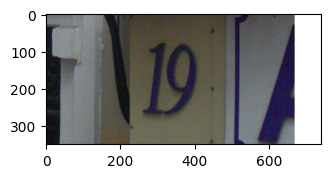

In [14]:
plt.close("all")

def visualize_fixed_bboxes(image_dir, y_train, num_show, rows, cols):
    """
    Loads images and displays them with matplotlib bounding boxes, handling
    NORMALIZED [Left, Top, Height, Width] format by swapping H and W for plotting.
    """
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))],
        key=lambda x: int(os.path.splitext(x)[0]) if os.path.splitext(x)[0].isdigit() else x
    )

    if not image_files:
        print(f"Error: No images found in {image_dir}")
        return

    num_show = min(num_show, len(image_files), len(y_train))
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    for i in range(num_show):
        try:
            # 1. Load the Image and get dimensions
            img_path = os.path.join(image_dir, image_files[i])
            image = Image.open(img_path)
            image_array = np.array(image)

            ax = axes[i]

            ax.imshow(image_array)

            boxes_for_image = y_train[i]

            width, height = image.size
            max_length = max(width, height)

            # --- Calculate Padding Offsets ---
            # These offsets are needed to convert from the 'squared' normalized space
            # back into the original image's coordinate system.
            pad_x = 0
            pad_y = 0

            if height > width:
                # Image was padded horizontally (left/right)
                pad_x = (height - width) / 2
            elif width > height:
                # Image was padded vertically (top/bottom)
                pad_y = (width - height) / 2

            # The normalization factor is the max dimension
            # max_length is already correctly calculated as max(width, height)

            for bbox in boxes_for_image:
                # The format in y_train is: [L, T, H, W]
                normalized_left, normalized_top, normalized_height, normalized_width = bbox

                if np.sum(bbox) == 0:
                    continue

                # --- RESCALE COORDINATES AND REMOVE PADDING OFFSET ---

                # 1. Rescale by multiplying by the normalization factor (max_length)
                left_rescaled = normalized_left * max_length
                top_rescaled = normalized_top * max_length

                # 2. Subtract the padding offset to get coordinates in the original image space
                left_pixel = left_rescaled - pad_x
                top_pixel = top_rescaled - pad_y

                # 3. Rescale Dimensions (dimensions do not have padding offset applied)
                pixel_width = normalized_width * max_length
                pixel_height = normalized_height * max_length

                # 4. Create the Matplotlib Bounding Box Patch (W, H are already correct from y_train)
                # Matplotlib requires (Left, Top, Width, Height)
                rect = patches.Rectangle(
                    (left_pixel, top_pixel), # Top-Left corner (NOW CORRECTED)
                    pixel_width,             # Width
                    pixel_height,            # Height                    linewidth=2,
                    edgecolor='blue',
                    facecolor='none'
                )

                ax.add_patch(rect)

            ax.set_title(f"Image: {image_files[i]}\n(L, T, H, W format)")
            ax.axis('off')

        except Exception as e:
            print(f"Could not process image {image_files[i]}: {e}")

    # Hide any unused subplots if num_show is less than ROWS * COLS
    for j in range(num_show, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

NUM_IMAGES_TO_SHOW = 20
IMAGE_DIR = 'data/train/'
COLS = 5
ROWS = int(np.ceil(NUM_IMAGES_TO_SHOW / COLS))
y_train = np.load("data/bboxes_only_train.npz", allow_pickle=True)
print(f"Attempting to display {NUM_IMAGES_TO_SHOW} images from {IMAGE_DIR} with normalized bboxes...")
visualize_fixed_bboxes(IMAGE_DIR, y_train, NUM_IMAGES_TO_SHOW, ROWS, COLS)

Manual label verification is very tedious and not feasible for 30k images in train/ folder, so we thought that we could filter the pictures somewhat by using an trained model's predictions it got wrong, so it would make the workload smaller, we used the images in train/ folder.

In [15]:

import keras
model_path = 'models/svhnModel.keras'

loaded_model = keras.models.load_model(model_path)

data_X_train = np.load("data/X_only_train.npz", allow_pickle=True)['arr_0']
data_y_train = np.load("data/bboxes_only_train.npz", allow_pickle=True)['arr_0']
data_labels_train = np.load("data/labels_only_train.npz", allow_pickle=True)['arr_0']

print(data_X_train.shape)
print(data_y_train.shape)
print(data_labels_train.shape)

ds_data = tf.data.Dataset.from_tensor_slices((data_X_train, {"bboxes": data_y_train, "classes": data_labels_train}))

ds_data = ds_data.batch(64).prefetch(tf.data.AUTOTUNE)


(33402, 128, 128, 1)
(33402, 6, 4)
(33402, 6)


2025-12-08 12:58:55.034450: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2189033472 exceeds 10% of free system memory.


In [16]:
results = loaded_model.evaluate(ds_data)
predictions = loaded_model.predict(ds_data)
print(results)
print('Test loss: %.4f accuracy: %.4f' % (results[2], results[4]))

2025-12-08 12:59:10.021381: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2189033472 exceeds 10% of free system memory.
2025-12-08 12:59:11.975805: I external/local_xla/xla/service/service.cc:163] XLA service 0x7313a4036e30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-08 12:59:11.975830: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-12-08 12:59:12.011386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-08 12:59:12.133158: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  1/522 ━━━━━━━━━━━━━━━━━━━━ 21:29 2s/step - bboxes_loss: 5.8775e-04 - bboxes_mse: 0.0012 - classes_accuracy: 0.9844 - classes_loss: 0.0711 - loss: 0.0994

I0000 00:00:1765191552.311385   47936 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


521/522 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - bboxes_loss: 6.4958e-04 - bboxes_mse: 0.0013 - classes_accuracy: 0.9793 - classes_loss: 0.1020 - loss: 0.1303

2025-12-08 13:00:41.730177: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


522/522 ━━━━━━━━━━━━━━━━━━━━ 92s 172ms/step - bboxes_loss: 6.4583e-04 - bboxes_mse: 0.0013 - classes_accuracy: 0.9795 - classes_loss: 0.1005 - loss: 0.1288
522/522 ━━━━━━━━━━━━━━━━━━━━ 89s 171ms/step
[0.12880194187164307, 0.0006458255229517817, 0.10047674179077148, 0.001291668857447803, 0.979451596736908]
Test loss: 0.1005 accuracy: 0.9795


In [17]:
bboxes_pred = predictions[0]  # Predicted BBoxes (N, 6, 4)
classes_pred = predictions[1] # Predicted Class Probabilities (N, 6, 11)

y_pred_classes = np.argmax(classes_pred, axis=2)

y_true_classes = data_labels_train

is_predicted_digit = (y_pred_classes != 0)

predicted_digit_counts = np.sum(is_predicted_digit, axis=1)
is_true_digit = (y_true_classes != 0)
true_digit_counts = np.sum(is_true_digit, axis=1) # Shape: (N,)

is_miscounted = (predicted_digit_counts != true_digit_counts)

mismatches = (y_pred_classes != y_true_classes)

is_image_misclassified = np.any(mismatches, axis=1)

counter = 0
for i in range(predictions[1].shape[0]):
    if is_image_misclassified[i] and is_miscounted[i] and true_digit_counts[i] < predicted_digit_counts[i]:
        # print(str(i+1) + ".png")
        # print(f'pred: {y_pred_classes[i]}, real: {y_true_classes[i]}')
        counter += 1
print(data_labels_train[36])
print(y_pred_classes[36])
print("Number of all images:", predictions[1].shape[0])
print("How many images to sift through (not correct because of overfitting:", counter)
print("Accuracy:", 1 - (counter / predictions[1].shape[0]))

[1. 1. 0. 0. 0. 0.]
[1 1 0 0 0 0]
Number of all images: 33402
How many images to sift through (not correct because of overfitting: 371
Accuracy: 0.9888928806658284


The problem came with overfitting (for example 37.png in train/, which should be the number 121, but because the label is 11 the model predicts it as such as well), technically we can't have access to the test dataset, so we had to check the validty of the training data with a model trained on that data, but this didn't
 yield any results obviously because there were many cases where the labels were incorrect, but the model still predicted it to be correct. One way to fix this is to split the training data for example in half, and validate the second half, but our models accuracy still wasn't good enough for this (in part because of the bad data), and halving the training data will surely make it worse. In a way it is a chicken and egg problem. One way to fix this problem is introducing extra data from extra/
 to make the model more accurate to less data to sift through. Sadly this would also mean the absolute number of images to verify increases as well. Finally, we did not use update bad_data in the end because of these reasons.